In [25]:
import torch
import torch.nn as nn
from typing import Optional
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os

In [26]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [27]:
device = torch.device("cuda")

In [28]:
def plotLoss(loss: list, type: str) -> None:
        
        """
        plotLoss is a function that plots the loss of the model

        Args:
            loss (list): it takes a list of loss
            type (str): it takes a string of the type of loss
        """        
        
        plt.plot(loss)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{type} Loss')
        plt.show()

In [229]:
class MyPlannerTransformer(nn.Module):
    
    def __init__(self, d_model=16,nhead = 2,num_encoder_layers = 2, num_decoder_layers=2, dropout = 0.1, dim_feedforward = 2048) -> None:
        super().__init__()
        self.transformer = nn.Transformer(
            d_model,
            nhead,
            num_encoder_layers,
            num_decoder_layers,
            dim_feedforward,
            dropout,
            batch_first=True
        )
        # map tgt to have the same number of features as src
        self.input = nn.Linear(5, d_model)
        self.tgt = nn.Linear(2, d_model)
        self.output = nn.Linear(d_model, 2)

    def forward(
        self,
        src: torch.tensor,
        tgt: torch.tensor,
        src_mask: Optional[torch.tensor]=None,
        tgt_mask: Optional[torch.tensor]=None,
        memory_mask: Optional[torch.tensor]=None,
        src_key_padding_mask: Optional[torch.tensor]=None,
        tgt_key_padding_mask: Optional[torch.tensor]=None,
        memory_key_padding_mask: Optional[torch.tensor]=None,
        max_len: Optional[int]=None,
        
    )->torch.tensor:

        src = self.input(src)
        tgt = self.tgt(tgt)
        # srcMask = self.generate_square_subsequent_mask(src.size(1)).to(device)
        # tgtMask = self.generate_square_subsequent_mask(tgt.size(1)).to(device)
        out = self.transformer(src, tgt)
        out = out[:,:,:2]
        return out
    
    
    def predict(self, src: torch.tensor, tgt: Optional[torch.tensor] = None) -> torch.tensor:
        
        """
        predict v3 is a function that uses the transformer model to predict the next waypoints
        it works by auto-regressive property of the transformer model
        this function is used to predict the entire sequence at once
        
        Args:
            src (torch.tensor):
            
            takes a tensor of shape (sequence, 5)
            in our case sequence is 10 and 5 is the number of features
            
        Returns:
            torch.tensor:
            
            tgt tensor of shape (outputSequence, 2)
            outputSequence is the number of waypoints to predict
            2 is the number of features
        """
        
        self.eval()
        src = src.reshape(-1, 10, 5)

        if tgt is None:
            tgt = torch.zeros((1, 1, 2)).cuda()
        with torch.no_grad():
                # srcMask = self.generate_square_subsequent_mask(src.size(1)).to(device)
                # tgtMask = self.generate_square_subsequent_mask(tgt.size(1)).to(device)
                for _ in range(15):
                    prediction = self.forward(src, tgt)
                    tgt = torch.cat((tgt, prediction[:,-1:]), dim=1)

        return tgt.reshape(-1,2)
    
    # def generate_square_subsequent_mask(self, sz):
    #     mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    #     mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    #     return mask
    

        
    

In [75]:
def createModel(path: str) -> MyPlannerTransformer:
    """
    Create a planning model from a saved state dict

    Parameters
    ----------
    path : str
        Path to the saved state dict

    Returns
    -------
    MyPlannerTransformer
        Planning model with the saved state dict loaded
    """
    model = MyPlannerTransformer()
    model.load_state_dict(torch.load(path))
    model.cuda()
    return model

In [31]:
class DataSet1():
    
    def __init__(self,) -> None:
        pass

    
    def __loadData(self,dir: str) -> torch.tensor: 
        data = torch.load(dir).cuda()
        return data
    
    def prepareData(self,trainDir: str, validDir) -> torch.tensor:
        srcTrain = self.__loadData(f'{trainDir}/src_train.pt')
        tgtTrain = self.__loadData(f'{trainDir}/tgt_train.pt')
        srcValid = self.__loadData(f'{validDir}/src_valid.pt')
        tgtValid = self.__loadData(f'{validDir}/tgt_valid.pt')
        
        srcSeqLength = 10
        srcNumOfSequencesTrain = srcTrain.size(0) // srcSeqLength
        tgtSeqLength = 4
        tgtNumOfSequencesTrain = tgtTrain.size(0) // tgtSeqLength
        srcNumOfSequencesValid = srcValid.size(0) // srcSeqLength
        tgtNumOfSequencesValid = tgtValid.size(0) // tgtSeqLength
        # reshape the tensors
        srcTrain = srcTrain[:srcNumOfSequencesTrain * srcSeqLength, :].view(srcNumOfSequencesTrain, srcSeqLength, -1).cuda()
        tgtTrain = tgtTrain[:tgtNumOfSequencesTrain * tgtSeqLength, :].view(tgtNumOfSequencesTrain, tgtSeqLength, -1).cuda()
        srcValid = srcValid[:srcNumOfSequencesValid * srcSeqLength, :].view(srcNumOfSequencesValid, srcSeqLength, -1).cuda()
        tgtValid = tgtValid[:tgtNumOfSequencesValid * tgtSeqLength, :].view(tgtNumOfSequencesValid, tgtSeqLength, -1).cuda()
        
        return srcTrain, tgtTrain, srcValid, tgtValid

In [32]:
class DataSet2():
    
    def __init__(self, srcSeqLength, tgtSeqLength, srcNumofFeatures, tgtNumofFeatures):
        
        self.srcSeqLength = srcSeqLength
        self.tgtSeqLength = tgtSeqLength
        self.srcNumofFeatures = srcNumofFeatures
        self.tgtNumofFeatures = tgtNumofFeatures
        
    
    def prepareData(self, srcPath, tgtPath, train = True):
        src = torch.empty(0, self.srcNumofFeatures).cuda()
        tgt = torch.empty(0, self.tgtNumofFeatures).cuda()
        if train:
            for files in os.listdir(srcPath+"train"):
                src = torch.cat((src, torch.load(f'{srcPath+"train"}/{files}').cuda())).cuda()
            numberOfSamples = src.size(0)
            for files in os.listdir(tgtPath+"train"):
                tgt = torch.cat((tgt, torch.load(f'{tgtPath+"train"}/{files}').cuda())).cuda()
                if tgt.size(0) > numberOfSamples:
                    break
        else:
            for files in os.listdir(srcPath+"valid"):
                src = torch.cat((src, torch.load(f'{srcPath+"valid"}/{files}').cuda())).cuda()
            numberOfSamples = src.size(0)
            for files in os.listdir(tgtPath+"valid"):
                tgt = torch.cat((tgt, torch.load(f'{tgtPath+"valid"}/{files}').cuda())).cuda()
                if tgt.size(0) > numberOfSamples:
                    break
                  
        srcNumOfSequencesTrain = src.size(0) // self.srcSeqLength
        tgtNumOfSequencesTrain = tgt.size(0) // self.tgtSeqLength
        
        # reshape the tensors
        src = src[:srcNumOfSequencesTrain * self.srcSeqLength, :].view(srcNumOfSequencesTrain, self.srcSeqLength, -1).cuda()
        tgt = tgt[:tgtNumOfSequencesTrain * self.tgtSeqLength, :].view(tgtNumOfSequencesTrain, self.tgtSeqLength, -1).cuda()
    
        return src, tgt

In [33]:
data1 = DataSet1()

In [34]:
data2 = DataSet2(srcSeqLength=10, tgtSeqLength=4, srcNumofFeatures=5, tgtNumofFeatures=2)

In [35]:
src_path = "../inputs/tensorsV2/inputs/"  # Replace with the path to your directory
tgt_path = "../inputs/tensorsV2/outputs/"

In [36]:
# srcTrain, tgtTrain, srcValid, tgtValid = data1.prepareData('../inputs/tensors/train', '../inputs/tensors/valid')

In [76]:
srcTrain, tgtTrain = data2.prepareData(src_path, tgt_path, train = True)

In [77]:
srcValid, tgtValid = data2.prepareData(src_path, tgt_path, train = False)

In [39]:
srcTrain.shape, tgtTrain.shape, srcValid.shape, tgtValid.shape

(torch.Size([153496, 10, 5]),
 torch.Size([383775, 4, 2]),
 torch.Size([8683, 10, 5]),
 torch.Size([21975, 4, 2]))

In [226]:
# suffle src
perm = torch.randperm(srcTrain.size(0))
srcTrain = srcTrain[perm]

In [227]:
trainData = list(zip(srcTrain, tgtTrain))
validData = list(zip(srcValid, tgtValid))

trainLoader = DataLoader(trainData, batch_size=100, shuffle=True)
validLoader = DataLoader(validData, batch_size=100, shuffle=True)

In [228]:
len(trainLoader.dataset)

153496

In [239]:
model = MyPlannerTransformer()

In [240]:
model.to(device)

MyPlannerTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [233]:
def trainModel(model, trainLoader, validLoader,criterion,optimizer,epochs = 10):
        
        """
        
        trainModel is a function that trains the model
        it also prints the loss and validation loss for each epoch
        it returns the loss and validation loss for each epoch as a list
        
        Returns:
            list: TRAIN_LOSS
            list: VAL_LOSS
        """        
        VAL_LOSS = []
        TRAIN_LOSS = []

        for epoch in range(epochs):
            model.train()
            total_loss = 0.0

            for batch_idx, (src, tgt) in enumerate(trainLoader):
               

                optimizer.zero_grad()
                output = model(src, tgt[:, :-1, :])  # Use teacher forcing for training

                # Flatten the output and target for computing the loss
                loss = criterion(output.view(-1, 2), tgt[:, 1:, :].contiguous().view(-1, 2))
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            average_loss = total_loss / len(trainLoader)
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {average_loss:.4f}")
            TRAIN_LOSS.append(average_loss)

            #Validation
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                for val_src, val_tgt in validLoader:
                    
                    val_output = model(val_src, val_tgt[:, :-1, :])  # No teacher forcing for validation
                    val_loss += criterion(val_output.view(-1, 2), val_tgt[:, 1:, :].contiguous().view(-1, 2)).item()

            average_val_loss = val_loss / len(validLoader)
            print(f"Validation Loss: {average_val_loss:.4f}")
            VAL_LOSS.append(average_val_loss)

        return TRAIN_LOSS, VAL_LOSS
    

In [241]:
train_loss, val_loss =  trainModel(model, trainLoader,validLoader, epochs=50)

Epoch [1/50], Loss: 664.6420
Validation Loss: 711.4679
Epoch [2/50], Loss: 492.0091
Validation Loss: 537.9363
Epoch [3/50], Loss: 356.5666
Validation Loss: 397.0828
Epoch [4/50], Loss: 250.7893
Validation Loss: 284.7462
Epoch [5/50], Loss: 170.2994
Validation Loss: 197.1962
Epoch [6/50], Loss: 111.2101
Validation Loss: 131.3579
Epoch [7/50], Loss: 69.6415
Validation Loss: 83.9611
Epoch [8/50], Loss: 41.7608
Validation Loss: 51.7725
Epoch [9/50], Loss: 24.0110
Validation Loss: 30.8891
Epoch [10/50], Loss: 13.2424
Validation Loss: 17.7630
Epoch [11/50], Loss: 7.0180
Validation Loss: 9.9777
Epoch [12/50], Loss: 3.6022
Validation Loss: 5.7097
Epoch [13/50], Loss: 1.8195
Validation Loss: 3.3839
Epoch [14/50], Loss: 0.9558
Validation Loss: 2.0266
Epoch [15/50], Loss: 0.5505
Validation Loss: 1.6296
Epoch [16/50], Loss: 0.3637
Validation Loss: 1.2200
Epoch [17/50], Loss: 0.2728
Validation Loss: 1.0216
Epoch [18/50], Loss: 0.2313
Validation Loss: 1.0679
Epoch [19/50], Loss: 0.2135
Validation Lo

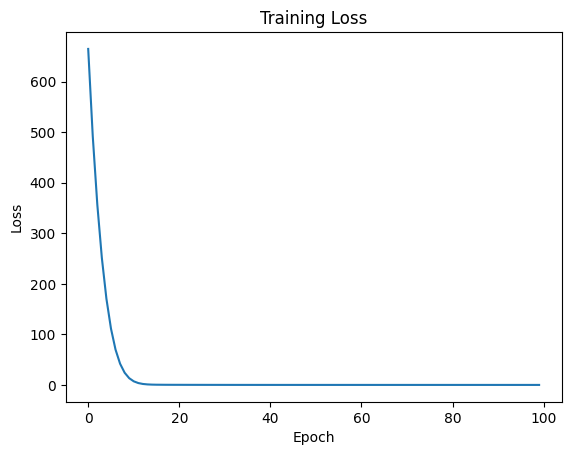

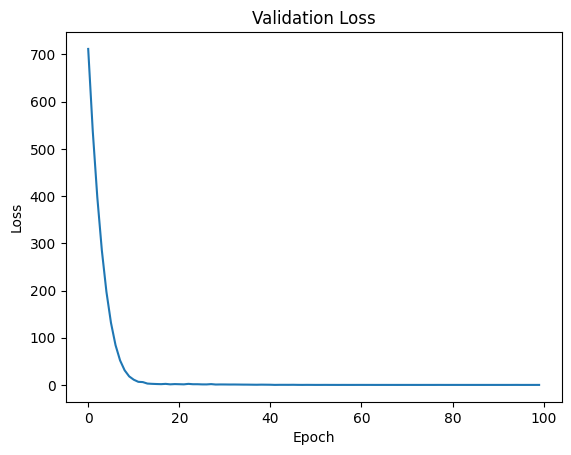

In [51]:
plotLoss(train_loss, 'Training')
plotLoss(val_loss, 'Validation')

tensor([[0.0000, 0.0000],
        [0.1430, 0.1313],
        [0.2944, 0.2614],
        [0.4545, 0.3899],
        [0.6234, 0.5173]], device='cuda:0')
tensor([[-1.7764e-15, -4.4409e-16],
        [ 1.5854e-01,  1.4291e-01],
        [ 3.2718e-01,  2.8220e-01],
        [ 5.0564e-01,  4.1798e-01]], device='cuda:0')


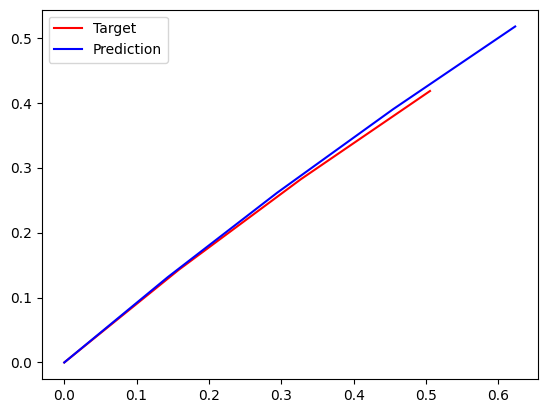

tensor([[0.6234, 0.5173],
        [0.8065, 0.6408],
        [0.9978, 0.7644],
        [1.1979, 0.8890],
        [1.4076, 1.0137]], device='cuda:0')
tensor([[0.6937, 0.5503],
        [0.8911, 0.6794],
        [1.0975, 0.8052],
        [1.3128, 0.9279]], device='cuda:0')


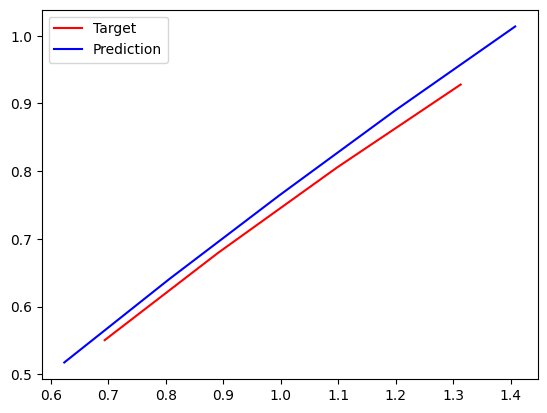

tensor([[1.4076, 1.0137],
        [1.6316, 1.1327],
        [1.8631, 1.2469],
        [2.1026, 1.3576],
        [2.3498, 1.4650]], device='cuda:0')
tensor([[1.5366, 1.0476],
        [1.7687, 1.1644],
        [2.0089, 1.2784],
        [2.2569, 1.3897]], device='cuda:0')


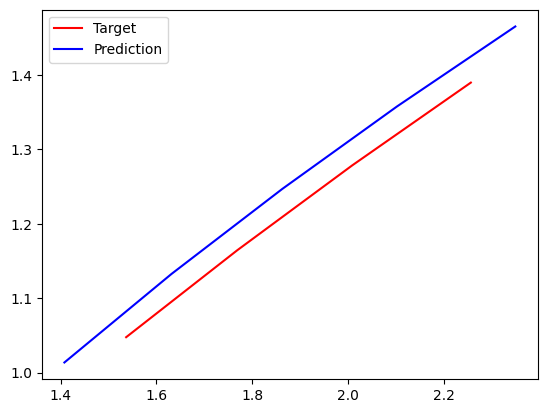

tensor([[2.3498, 1.4650],
        [2.6080, 1.5662],
        [2.8730, 1.6644],
        [3.1456, 1.7602],
        [3.4262, 1.8541]], device='cuda:0')
tensor([[2.5124, 1.4983],
        [2.7752, 1.6045],
        [3.0450, 1.7083],
        [3.3216, 1.8097]], device='cuda:0')


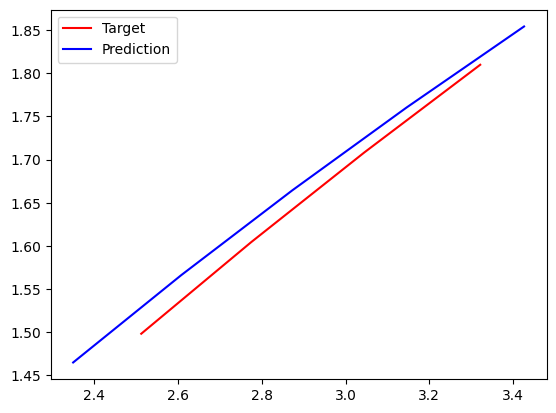

tensor([[3.4262, 1.8541],
        [3.7166, 1.9421],
        [4.0138, 2.0279],
        [4.3180, 2.1114],
        [4.6290, 2.1929]], device='cuda:0')
tensor([[3.6047, 1.9090],
        [3.8941, 2.0062],
        [4.1895, 2.1014],
        [4.4906, 2.1947]], device='cuda:0')


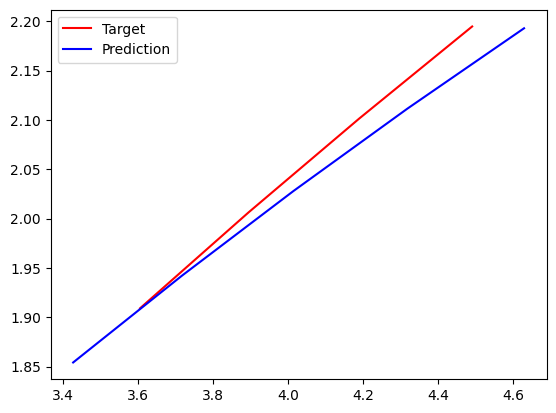

In [246]:
for i in range(5):
    src = srcValid[i]
    tgt = tgtValid[i]
    if i!=0:
        prediction = model.predict(src, prediction[-1].reshape(1,1,2))
    else:
        prediction = model.predict(src)
    print(prediction)
    print(tgt)
    plt.plot(tgt[:, 0].cpu().numpy(), tgt[:, 1].cpu().numpy(), 'r')
    plt.plot(prediction[:, 0].cpu().numpy(), prediction[:, 1].cpu().numpy(), 'b')
    plt.legend(['Target', 'Prediction'])
    plt.show()

In [22]:
torch.save(model.state_dict(), '../notebooks/myPlannerTransformer.pt')

model.load_state_dict(torch.load('../notebooks/myPlannerTransformer.pt'))


def pathPredict(model, src: torch.tensor,tgt: Optional[torch.tensor] = None):
        
    try:
        last_prediction = torch.load('../notebooks/lastPredicitons.pt')
        output = model.predict(src, last_prediction)
        torch.save(output[-1].reshape(1,-1,2), '../notebooks/lastPredicitons.pt')
        return output
    except:
        output = model.predict(src)
        torch.save(output[-1].reshape(1,-1,2), '../notebooks/lastPredicitons.pt')
        return output
